 # Classificação de Sentimentos no Dataset "Restaurant Reviews" com o Modelo DistilBERT.

### Descrição do Dataset

Nesse trabalho, será analisado um dataset que contém reviews de restaurantes europeus. O dataset inclui informações como o o nome do restaurante, o país em que ele está localizado, o sentimento da avaliação (positivo ou negativo), o título da avaliação e o conteúdo da avaliação.

### Carregamento do Dataset



In [14]:
import pandas as pd
df=pd.read_csv("~/TP2.IA/European Restaurant Reviews.csv")

 Visualização do conteúdo e da estrutura do dataset

In [15]:
df.head()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
0,France,The Frog at Bercy Village,Negative,Rude manager,May 2024 •,The manager became agressive when I said the c...
1,France,The Frog at Bercy Village,Negative,A big disappointment,Feb 2024 •,"I ordered a beef fillet ask to be done medium,..."
2,France,The Frog at Bercy Village,Negative,Pretty Place with Bland Food,Nov 2023 •,"This is an attractive venue with welcoming, al..."
3,France,The Frog at Bercy Village,Negative,Great service and wine but inedible food,Mar 2023 •,Sadly I used the high TripAdvisor rating too ...
4,France,The Frog at Bercy Village,Negative,Avoid- Worst meal in Rome - possibly ever,Nov 2022 •,From the start this meal was bad- especially g...


Quantidade de observações, quantidade de dados ausentes e tipo de cada coluna

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1502 entries, 0 to 1501
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Country          1502 non-null   object
 1   Restaurant Name  1502 non-null   object
 2   Sentiment        1502 non-null   object
 3   Review Title     1502 non-null   object
 4   Review Date      1502 non-null   object
 5   Review           1502 non-null   object
dtypes: object(6)
memory usage: 70.5+ KB


Conclusão do carregamento

O Dataset possui 1502 observações com 6 colunas: Country (País), Restaurant Name (Nome do Restaurante), Review Title (Título da Avaliação), Review Date (Data da Avaliação), Review (Avaliação) e não possui nenhum dado ausente em nenhuma das 6 colunas, portanto, não será necessária nenhuma técnica de pré-processamento para lidar com dados ausentes. Todas as colunas são do tipo object (string).

### Informações do dataset

In [17]:
df.describe()

,Country,Restaurant Name,Sentiment,Review Title,Review Date,Review
count,1502,1502,1502,1502,1502,1502
unique,7,7,2,1343,143,1426
top,France,The Frog at Bercy Village,Positive,Excellent,May 2014 •,I'm afraid we were very let down by this resta...
freq,512,512,1237,9,108,4


O dataset contém dados de 7 restaurantes de 7 diferentes países.

Distribuição de sentimentos

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

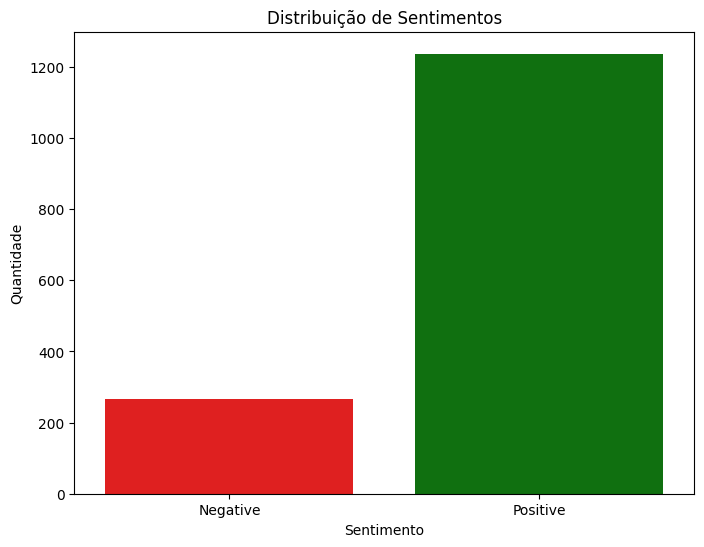

In [19]:
plt.figure(figsize=(8,6))
sns.countplot(x="Sentiment", data=df, hue="Sentiment" ,palette=['red', 'green'], legend=False) 
plt.title("Distribuição de Sentimentos")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.show()

Das 1502 observações, 1237 são positivas e 265 negativas.

Média de tamanho da avaliação de acordo com o sentimento

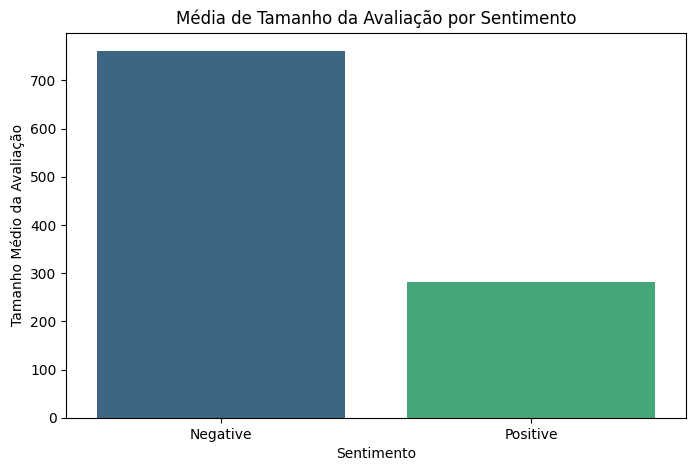

In [20]:
df['Review Length'] = df['Review'].apply(len)
avg_review_length = df.groupby('Sentiment')['Review Length'].mean()
plt.figure(figsize=(8, 5))
sns.barplot(x=avg_review_length.index, y=avg_review_length.values, hue=avg_review_length.index,palette='viridis')
plt.title('Média de Tamanho da Avaliação por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Tamanho Médio da Avaliação')
plt.show()

Esse gráfico mostra que as avaliações negativas tendem a ser muito mais longas do que as avaliações positivas (As positivas costumam ter cerca de 300 caracteres, enquanto as positivas costumam ter cerca de 700 caracteres). Isso evidencia que, quando os clientes estão insatisfeitos, eles costumam avaliar de forma mais detalhada em comparação a quando eles estão satisfeitos. Esse elemento pode ser utilizado pelo modelo de classificação de sentimentos para uma classificação mais precisa.

Quantidade de avaliações separadas por país

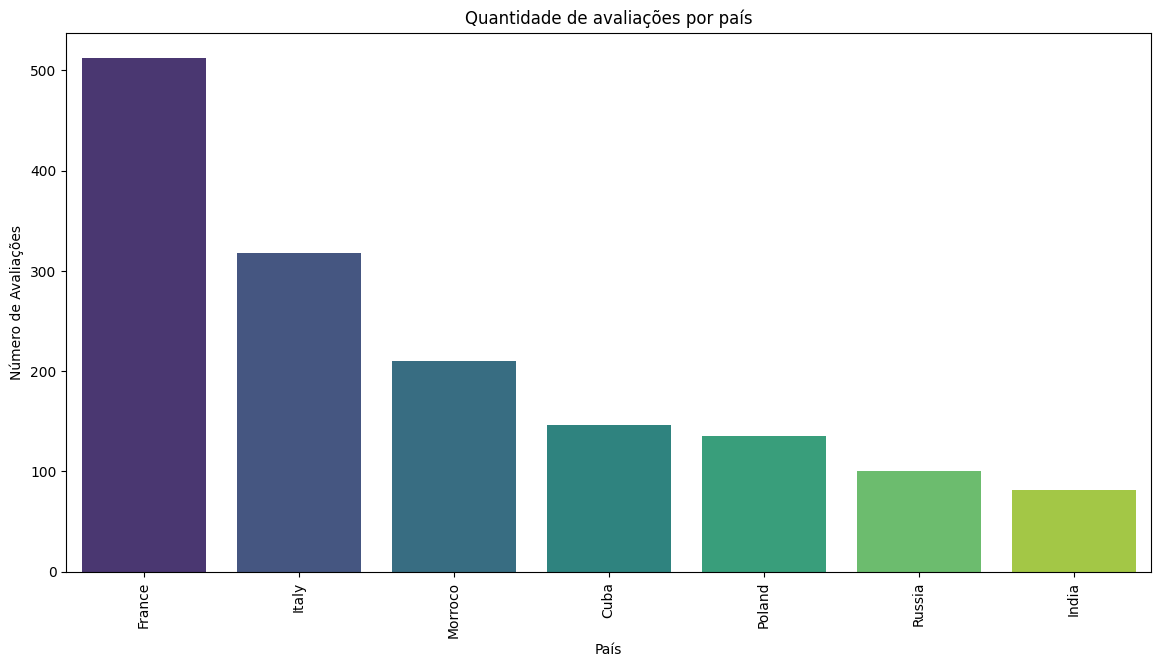

In [21]:
plt.figure(figsize=(14,7))
country_count=df["Country"].value_counts()
sns.barplot(x=country_count.index,y=country_count.values, hue=country_count.index, palette="viridis")
plt.title("Quantidade de avaliações por país")
plt.xlabel("País")
plt.ylabel("Número de Avaliações")
plt.xticks(rotation=90)
plt.show()

Os países da parte central da Europa possuem uma quantidade maior de avaliações, evidenciando uma possível cultura culinária mais forte nesses países.

Nuvem de palavras mais utilizadas em avaliações positivas

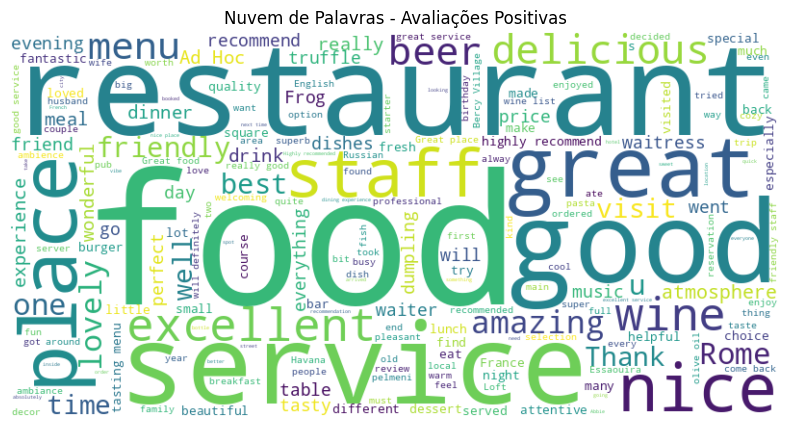

In [22]:
from wordcloud import WordCloud

positive_reviews = df[df['Sentiment'] == 'Positive']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras - Avaliações Positivas')
plt.axis('off')
plt.show()

Nuvem de palavras mais utilizadas em avaliações negativas

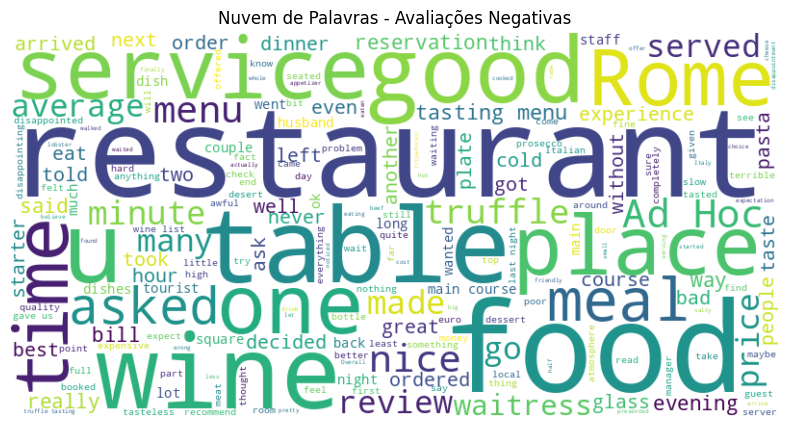

In [23]:
from wordcloud import WordCloud

positive_reviews = df[df['Sentiment'] == 'Negative']['Review'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras - Avaliações Negativas')
plt.axis('off')
plt.show()

As palavras mais frequentes para cada tipo de sentimento são importantes informações para o modelo de linguagem classificar sentimentos com a maior acurácia possível. Porém, algumas palavras podem estar igualmente presentes em grande quantidade em ambos os sentimentos, como a palavra "restaurante", por exemplo.

Média de sentimentos ao longo do tempo

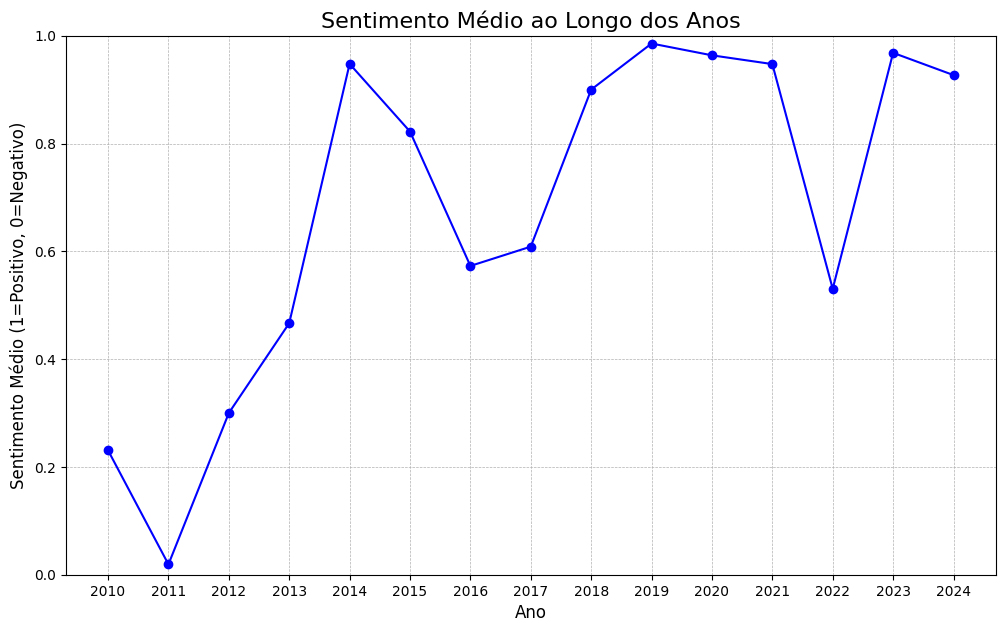

In [24]:
import re
import matplotlib.pyplot as plt
import pandas as pd

df_temp = df.copy()

# Extrair mês e ano (ex: "May 2024")
df_temp['Review Date'] = df_temp['Review Date'].str.extract(r'([A-Za-z]+\s+\d{4})')

# Corrigir abreviação não padrão "Sept"
df_temp['Review Date'] = df_temp['Review Date'].str.replace('Sept', 'Sep')

# Converter para datetime (dia 1 por padrão)
df_temp['Review Date'] = pd.to_datetime(df_temp['Review Date'], format='%b %Y', errors='coerce')

# Mapear sentimentos para valores numéricos
df_temp['Sentiment_Value'] = df_temp['Sentiment'].map({'Positive': 1, 'Negative': 0})

# Média de sentimento por ano
sentiment_by_year = df_temp.groupby(df_temp['Review Date'].dt.year)['Sentiment_Value'].mean()

# Plotar
plt.figure(figsize=(12, 7))
sentiment_by_year.plot(kind='line', marker='o', linestyle='-', color='b')

plt.title('Sentimento Médio ao Longo dos Anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Sentimento Médio (1=Positivo, 0=Negativo)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(sentiment_by_year.index)
plt.ylim(0, 1)
plt.show()


In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Caminho correto do CSV com expansão do ~
import os
csv_path = os.path.expanduser("~/TP2.IA/European Restaurant Reviews.csv")
df = pd.read_csv(csv_path)

texts = df['Review'].tolist()  # Ajuste se a coluna tiver outro nome

model_name = "tabularisai/multilingual-sentiment-analysis"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

def predict_sentiment(texts):
    # Processa em batches para evitar uso excessivo de memória
    batch_size = 8
    sentiment_map = {0: "Muito Negativo", 1: "Negativo", 2: "Neutro", 3: "Positivo", 4: "Muito Positivo"}
    all_preds = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
        preds = torch.argmax(probs, dim=-1).tolist()
        all_preds.extend([sentiment_map[p] for p in preds])
    return all_preds

resultados = predict_sentiment(texts)

for text, sentiment in zip(texts, resultados):
    print(f"Text: {text}\nSentiment: {sentiment}\n")


/home/aderson/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Text: The manager became agressive when I said the carbonara was not good. She was rude. It was  a very bad experience. The worst in Rome in many years.
Sentiment: Very Negative

Text: I ordered a beef fillet ask to be done medium, I got it well done cooked and very dry, when I told them they took the steak and after 20 minutes they brought me another steak that was completely rare, I left all the steak , and they asked me about it but charged me the fool price.
Sentiment: Positive

Text: This is an attractive venue with welcoming, albeit but somewhat slow service. The offerings are pleasingly presented but most everything has no taste. It was as though ingredients were just assembled without seasoning: a lovely restaurant, except for the food.
Sentiment: Neutral

Text: Sadly I  used the high TripAdvisor rating too literally. We have been fortunate to eat at a number of fine restaurants so  know that amazing buzz from  a mouthful of fine freshly cooked food from a great chef.
Never bef